In [70]:
import datetime as dt
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

def get_lte_handover_time(mi_df, pcap_df = None):

    if type(pcap_df) == type(None):
        lte_handover_time_list = []
        for i in range(len(mi_df)):
            if mi_df.loc[i, "lte-rrc.t304"]:
                lte_handover_time_list.append(mi_df.loc[i, "time"])
        return lte_handover_time_list
    else:
        begin_time = pcap_df.loc[0, "frame.time"]
        end_time = pcap_df.loc[pcap_df.index[-1], "frame.time"]
        print(begin_time, end_time)
        lte_handover_time_list = []
        for i in range(len(mi_df)):
            if mi_df.loc[i, "lte-rrc.t304"] and mi_df.loc[i, "time"] >= begin_time and mi_df.loc[i, "time"] <= end_time:
                lte_handover_time_list.append(mi_df.loc[i, "time"])
        return lte_handover_time_list
def get_nr_handover_time(mi_df, pcap_df = None):
    if type(pcap_df) == type(None):
        nr_handover_time_list = []
        for i in range(len(mi_df)):
            if mi_df.loc[i, "nr-rrc.t304"]:
                nr_handover_time_list.append(mi_df.loc[i, "time"])
        return nr_handover_time_list
    else:
        begin_time = pcap_df.loc[0, "frame.time"]
        end_time = pcap_df.loc[pcap_df.index[-1], "frame.time"]
        nr_handover_time_list = []
        for i in range(len(mi_df)):
            if mi_df.loc[i, "nr-rrc.t304"] and mi_df.loc[i, "time"] >= begin_time and mi_df.loc[i, "time"] <= end_time:
                nr_handover_time_list.append(mi_df.loc[i, "time"])
        return nr_handover_time_list

def get_failure_time(mi_df, pcap_df = None):
    if type(pcap_df) == type(None):
        failure_time_list = []
        for i in range(len(mi_df)):
            if mi_df.loc[i, "rrcConnectionReestablishmentRequest"] or mi_df.loc[i, "scgFailureInformationNR-r15"]:
                failure_time_list.append(mi_df.loc[i, "time"])
        return failure_time_list
    else:
        begin_time = pcap_df.loc[0, "frame.time"]
        end_time = pcap_df.loc[pcap_df.index[-1], "frame.time"]
        failure_time_list = []
        for i in range(len(mi_df)):
            if (mi_df.loc[i, "rrcConnectionReestablishmentRequest"] or mi_df.loc[i, "scgFailureInformationNR-r15"]) and mi_df.loc[i, "time"] >= begin_time and mi_df.loc[i, "time"] <= end_time:
                failure_time_list.append(mi_df.loc[i, "time"])
        return failure_time_list


def get_location_by_time(time_list, cellinfo_df, savefilename):
    i = 0
    j = 0
    f = None
    f = open(savefilename, 'w')
    f.write("latitude, longitude\n")    
    while i + 1< len(cellinfo_df) and j < len(time_list):
        if cellinfo_df.loc[i, "Date"] > time_list[j]:
            j += 1
        elif cellinfo_df.loc[i +1 , "Date"] < time_list[j]:
            i += 1
        else:
            f.write("%f,%f\n"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"]))
            j += 1
    f.close()
    
def get_ret(pcapdf):
    # get retransmision time list
    time_list = []
    for i in range(len(pcapdf)):
        if not np.isnan(pcapdf.loc[i, "tcp.analysis.retransmission"]) or not np.isnan(pcapdf.loc[i, "tcp.analysis.fast_retransmission"]):
            time_list.append(pcapdf.loc[i, "frame.time"])
    time_list = pd.to_datetime(time_list)
    return time_list

def read_pcapcsv(filename):
    df = pd.read_csv(filename, sep='@')
    df.loc[:, "frame.time"] = pd.to_datetime(df.loc[:, r"frame.time"]).dt.tz_localize(None)
    return df

def get_num_neiboring_cell(cellinfo_df, savefilename):
    num_col = len(cellinfo_df.columns)
    f = open(savefilename, 'w')
    f.write("latitude, longitude, num_cell\n")
    for i in range(len(cellinfo_df)):
        for j in range(17, num_col):
            if cellinfo_df.iloc[i, j] == '-':
                print("%f,%f,%d\n"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"], (j-17) // 4), file=f)
                # print(i, cellinfo_df.loc[i, "Date"] , (j-17) // 4) 
                break
            elif j == num_col -1:
                print("%f,%f,%d\n"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"], (j-17+1) // 4), file=f)
    f.close()

def get_pure_lte_location(cellinfo_df, savefilename):
    f = open(savefilename, 'w')
    f.write("latitude, longitude\n")
    for i in range(len(cellinfo_df)):
        if cellinfo_df.loc[i, "NR_SSRSRP"] == '-' and cellinfo_df.loc[i, "GPSLat"] < 25.005178 and cellinfo_df.loc[i, "GPSLon"] < 121.557875:
            print("%f,%f"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"]), file=f)

def get_nr_location(cellinfo_df, savefilename):
    f = open(savefilename, 'w')
    f.write("latitude, longitude\n")
    for i in range(len(cellinfo_df)):
        if cellinfo_df.loc[i, "NR_SSRSRP"] != '-' and cellinfo_df.loc[i, "GPSLat"] < 25.005178 and cellinfo_df.loc[i, "GPSLon"] < 121.557875:
            print("%f,%f"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"]), file=f)

def read_ss_file(filename):
    f = open(filename)
    l = f.readline()
    time_l = []
    cwnd_l = []
    while l:
        l = l.split(',')
        for i in range(len(l)-1):
            if l[i] == 'cwnd':
                time_l.append(l[0])
                cwnd_l.append(int(l[i+1]))
        l = f.readline()

        # if l[]
    time_l = pd.to_datetime(time_l)
    df = pd.DataFrame({'time': time_l, 'cwnd': cwnd_l})
    return df

def get_num_neiboring_cell_unique(cellinfo_df, savefilename):
    num_col = len(cellinfo_df.columns)
    f = open(savefilename, 'w')
    f.write("latitude, longitude, num_cell\n")
    for i in range(len(cellinfo_df)):
        cur_pci = cellinfo_df.loc[i, "PCI"]
        pci_set = set()
        for j in range(17, num_col, 4):
            if cellinfo_df.iloc[i, j] == '-':
                # print()
                # print("%f,%f,%d\n"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"], (j-17) // 4))
                # print(i, cellinfo_df.loc[i, "Date"] , (j-17) // 4) 
                break
            else:
                if cellinfo_df.iloc[i, j] != cur_pci:
                    pci_set.add(cellinfo_df.iloc[i, j])
                    # print(cellinfo_df.iloc[i, j])
            # elif j == num_col -1:
                # print("%f,%f,%d\n"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"], (j-17+1) // 4))
        if len(cellinfo_df.loc[i, "LTE_RSRP"]) > 1 and cellinfo_df.loc[i, "GPSLat"] < 25.005178 and cellinfo_df.loc[i, "GPSLon"] < 121.557875:
            print("%f,%f,%d"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"], len(pci_set)), file=f)
        # print("num_pci", )
    f.close()

def get_lte_RSRP(cellinfo_df, savefilename):
    num_col = len(cellinfo_df.columns)
    f = open(savefilename, 'w')
    f.write("latitude, longitude, LTE_RSRP\n")
    for i in range(len(cellinfo_df)):
        cur_pci = cellinfo_df.loc[i, "PCI"]
        pci_set = set()
        if len(cellinfo_df.loc[i, "LTE_RSRP"]) > 1 and cellinfo_df.loc[i, "GPSLat"] < 25.005178 and cellinfo_df.loc[i, "GPSLon"] < 121.557875:
            print("%f,%f,%s"%(cellinfo_df.loc[i, "GPSLat"], cellinfo_df.loc[i, "GPSLon"], cellinfo_df.loc[i, "LTE_RSRP"]), file=f)
        # print("num_pci", )
    f.close()

In [66]:
mi_file_path = "/home/wmnlab/D/xm09/0620/mi2log/diag_log_20220620_183952_e12871e9b44a8ba39fb612aa8f5ee5c5_Xiaomi-M2007J3SY_46697.mi2log.txt_3.csv"
mi_df = pd.read_csv(mi_file_path)
mi_df.loc[:, "time"] = pd.to_datetime(mi_df.loc[:, "time"]) + dt.timedelta(hours=8)

cellinfo_path = "/home/wmnlab/D/xm09/0620/cellinfo/062022060815_new.csv"
cellinfo_df = pd.read_csv(cellinfo_path)
cellinfo_df.loc[:, "Date"] = pd.to_datetime(cellinfo_df.loc[:, "Date"])


In [223]:
savefilename = '/home/wmnlab/D/jy/num_nei_cell_u.csv'

get_num_neiboring_cell_unique(cellinfo_df, savefilename)

In [240]:
savefilename = '/home/wmnlab/D/jy/LTE_RSRP.csv'

get_lte_RSRP(cellinfo_df, savefilename)

In [71]:
savefilename = '/home/wmnlab/D/jy/num_nei_cell.csv'

get_num_neiboring_cell(cellinfo_df, savefilename)

In [89]:
savefilename = '/home/wmnlab/D/jy/purelte.csv'

get_pure_lte_location(cellinfo_df,savefilename)

In [92]:
savefilename = '/home/wmnlab/D/jy/nr.csv'

get_nr_location(cellinfo_df,savefilename)

In [53]:
print(len(cellinfo_df.columns))

97


In [56]:
cellinfo_df.iloc[0, 17]

'71'

In [97]:
97-17

80

In [ ]:
print(len(cellinfo_df.columns))

In [16]:
lte_handover_time_list = get_lte_handover_time(mi_df)
nr_handover_time_list = get_nr_handover_time(mi_df)

In [17]:
print(len(lte_handover_time_list))
print(len(nr_handover_time_list))

41
311


In [93]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-15-01/server_DL_3277_2022-6-20-18-15-01_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)


In [118]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-15-01/server_DL_3277_2022-6-20-18-15-01_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round1_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round1_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round1_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)

2022-06-20 18:15:05.336746 2022-06-20 18:16:55.265406


In [119]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-16-56/server_DL_3277_2022-6-20-18-16-56_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round2_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round2_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round2_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)

2022-06-20 18:19:40.920264 2022-06-20 18:21:37.155737


In [150]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-21-38/server_DL_3277_2022-6-20-18-21-38_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round3_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round3_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round3_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)


2022-06-20 18:24:42.595653 2022-06-20 18:26:38.707888


WTF ['2022-06-20 18:25:55.744693', 'cubic', 'wscale', '7', '7', 'rto', '496', 'backoff', '1', 'rtt', '44.93/12.082', 'mss', '1358', 'pmtu', '1500', 'rcvmss', '536', 'advmss', '1448', 'cwnd', '1', 'ssthresh', '42', 'bytes_sent', '46820027', 'bytes_retrans', '91500', 'bytes_acked', '46645851', 'segs_out', '35700', 'segs_in', '12085', 'data_segs_out', '35700', 'send', '241.8Kbps', 'lastsnd', '12', 'lastrcv', '73124', 'lastack', '496', 'pacing_rate', '17.4Mbps', 'delivery_rate', '9.8Mbps', 'delivered', '35572', 'app_limited', 'busy', '69988ms', 'unacked', '61', 'retrans', '1/68', 'lost', '61', 'rcv_space', '14600', 'rcv_ssthresh', '64076', 'notsent', '241478', 'minrtt', '17.945\n']
WTF ['2022-06-20 18:26:03.913114', 'cubic', 'wscale', '7', '7', 'rto', '464', 'backoff', '1', 'rtt', '29.811/2.187', 'mss', '1358', 'pmtu', '1500', 'rcvmss', '536', 'advmss', '1448', 'cwnd', '1', 'ssthresh', '27', 'bytes_sent', '52874535', 'bytes_retrans', '216274', 'bytes_acked', '52605027', 'segs_out', '40595'

(20.0, 121.12326765)

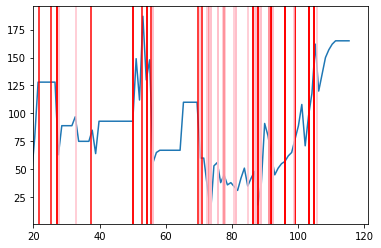

In [151]:


ss_filename = '/home/wmnlab/D/hicloudserver/0620/ss/ss_server_DL_3277_2022-6-20-18-24-43.csv'
ss_df = read_ss_file(ss_filename)
begin_time = ss_df.loc[0, "time"]
# plt.plot(ss_df.loc[:, "time"]-begin_time, ss_df.loc[:, "cwnd"])
x = []
y = []
for i in range(len(ss_df)):
    x.append((ss_df.loc[i, "time"]-begin_time).total_seconds())
    y.append(ss_df.loc[i, "cwnd"])

plt.plot(x, y)

for handovertime in lte_handover_time_list + nr_handover_time_list:
    plt.axvline((handovertime - begin_time).total_seconds(), c = 'r')
# for handovertime in nr_handover_time_list:
    # plt.axvline(handovertime, c = 'g')
for ret_time in ret_time_list:
    plt.axvline((ret_time - begin_time).total_seconds(), c = 'pink')


plt.xlim(left = 20)



In [121]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-26-39/server_DL_3277_2022-6-20-18-26-39_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round4_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round4_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round4_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)


2022-06-20 18:28:30.660653 2022-06-20 18:29:07.135244


In [148]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-29-08/server_DL_3277_2022-6-20-18-29-08_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round5_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round5_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round5_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)


2022-06-20 18:29:09.829905 2022-06-20 18:30:24.443102


(20.0, 73.91411264999999)

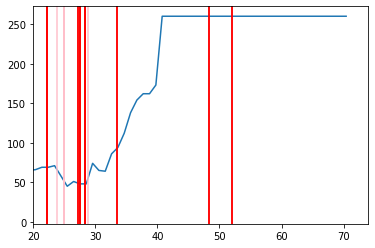

In [149]:
ss_filename = '/home/wmnlab/D/hicloudserver/0620/ss/ss_server_DL_3277_2022-6-20-18-29-13.csv'
ss_df = read_ss_file(ss_filename)
begin_time = ss_df.loc[0, "time"]
# plt.plot(ss_df.loc[:, "time"]-begin_time, ss_df.loc[:, "cwnd"])
x = []
y = []
for i in range(len(ss_df)):
    x.append((ss_df.loc[i, "time"]-begin_time).total_seconds())
    y.append(ss_df.loc[i, "cwnd"])

plt.plot(x, y)

for handovertime in lte_handover_time_list + nr_handover_time_list:
    plt.axvline((handovertime - begin_time).total_seconds(), c = 'r')
# for handovertime in nr_handover_time_list:
    # plt.axvline(handovertime, c = 'g')
for ret_time in ret_time_list:
    plt.axvline((ret_time - begin_time).total_seconds(), c = 'pink')


plt.xlim(left = 20)


In [127]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-30-25/server_DL_3277_2022-6-20-18-30-25_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round6_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round6_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round6_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)


2022-06-20 18:33:09.183604 2022-06-20 18:35:04.076495


In [129]:
lte_handover_time_list

[Timestamp('2022-06-20 18:34:01.495529'),
 Timestamp('2022-06-20 18:34:05.003070'),
 Timestamp('2022-06-20 18:34:26.597104'),
 Timestamp('2022-06-20 18:34:35.885597'),
 Timestamp('2022-06-20 18:34:42.375902'),
 Timestamp('2022-06-20 18:34:46.003213'),
 Timestamp('2022-06-20 18:34:53.497112')]

WTF ['2022-06-20 18:34:47.315717', 'cubic', 'wscale', '7', '7', 'rto', '848', 'backoff', '1', 'rtt', '195.384/18.455', 'mss', '1358', 'pmtu', '1500', 'rcvmss', '536', 'advmss', '1448', 'cwnd', '1', 'ssthresh', '28', 'bytes_sent', '47160185', 'bytes_retrans', '31460', 'bytes_acked', '47074005', 'segs_out', '35727', 'segs_in', '11367', 'data_segs_out', '35727', 'send', '55.6Kbps', 'lastsnd', '140', 'lastrcv', '98060', 'lastack', '1520', 'pacing_rate', '5.4Mbps', 'delivery_rate', '9.3Mbps', 'delivered', '35664', 'app_limited', 'busy', '65260ms', 'unacked', '41', 'retrans', '1/26', 'lost', '41', 'dsack_dups', '3', 'rcv_space', '14600', 'rcv_ssthresh', '64076', 'notsent', '167680', 'minrtt', '17.457\n']


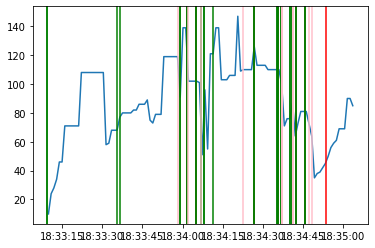

In [136]:
ss_filename = '/home/wmnlab/D/hicloudserver/0620/ss/ss_server_DL_3277_2022-6-20-18-33-9.csv'
ss_df = read_ss_file(ss_filename)
plt.plot(ss_df.loc[:, "time"], ss_df.loc[:, "cwnd"])
for handovertime in lte_handover_time_list:
    plt.axvline(handovertime, c = 'r')
for handovertime in nr_handover_time_list:
    plt.axvline(handovertime, c = 'g')
for ret_time in ret_time_list:
    plt.axvline(ret_time, c = 'pink')




In [59]:
pcap_path = "/home/wmnlab/D/redundant/0620/server_dl_pcap/2022-6-20-18-35-04/server_DL_3277_2022-6-20-18-35-04_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)
savefilename = '/home/wmnlab/D/jy/round7_ret.csv'
get_location_by_time(ret_time_list, cellinfo_df, savefilename)
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
savefilename = '/home/wmnlab/D/jy/round7_enbho.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)
savefilename = '/home/wmnlab/D/jy/round7_gnbho.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)

faliure_time_list = get_failure_time(mi_df, pcap_df)


2022-06-20 18:36:15.558080 2022-06-20 18:38:15.920863


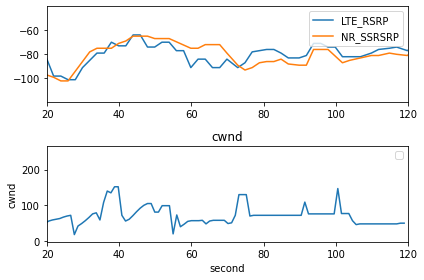

In [67]:
ss_filename = '/home/wmnlab/D/hicloudserver/0620/ss/ss_server_DL_3277_2022-6-20-18-36-16.csv'
ss_df = read_ss_file(ss_filename)


begin_time = max(ss_df.loc[0, "time"], mi_df.loc[0, "time"] )
# plt.plot(ss_df.loc[:, "time"]-begin_time, ss_df.loc[:, "cwnd"])

# LTE RSRP
LTE_X_list = []
LTE_Y_list = []

NR_X_list = []
NR_Y_list = []


plt.subplot(2, 1, 1)

for i in range(len(cellinfo_df)):
    if cellinfo_df.loc[i, "LTE_RSRP"] != "-":
        LTE_X_list.append((cellinfo_df.loc[i, "Date"] - begin_time).total_seconds())
        LTE_Y_list.append(int(cellinfo_df.loc[i, "LTE_RSRP"]))

plt.plot(LTE_X_list, LTE_Y_list, label = "LTE_RSRP")


for i in range(len(cellinfo_df)):
    if cellinfo_df.loc[i, "NR_SSRSRP"] != "-":
        NR_X_list.append((cellinfo_df.loc[i, "Date"] - begin_time).total_seconds())
        NR_Y_list.append(int(cellinfo_df.loc[i, "NR_SSRSRP"]))

plt.plot(NR_X_list, NR_Y_list, label = "NR_SSRSRP")


plt.xlim(left = 20, right = 120)

plt.legend(loc="upper right")


x = []
y = []
for i in range(len(ss_df)):
    x.append((ss_df.loc[i, "time"]-begin_time).total_seconds())
    y.append(ss_df.loc[i, "cwnd"])


plt.subplot(2, 1, 2)

plt.plot(x, y)

for handovertime in lte_handover_time_list + nr_handover_time_list:
    plt.axvline((handovertime - begin_time).total_seconds(), c = 'g', label = "packet retransmission")



i = 0
j = 0

while i + 1< len(ss_df) and j < len(lte_handover_time_list):
    if ss_df.loc[i, "time"] > lte_handover_time_list[j]:
        j += 1
    elif ss_df.loc[i + 1, "time"] < lte_handover_time_list[j]:
        i += 1
    else:
        plt.scatter((ss_df.loc[i, "time"] - begin_time).total_seconds(), ss_df.loc[i, "cwnd"], c = 'r', label = "handover")
        j += 1

i = 0
j = 0

while i + 1< len(ss_df) and j < len(faliure_time_list):
    if ss_df.loc[i, "time"] > faliure_time_list[j]:
        j += 1
    elif ss_df.loc[i + 1, "time"] < faliure_time_list[j]:
        i += 1
    else:
        plt.scatter((ss_df.loc[i, "time"] - begin_time).total_seconds(), ss_df.loc[i, "cwnd"], c = 'orange', label = "disconnected")
        j += 1



handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title("cwnd")
plt.legend(by_label.values(), by_label.keys())
plt.xlabel("second")
plt.ylabel("cwnd")
plt.xlim(left = 20, right = 120)

plt.tight_layout()





In [63]:
ss_df = read_ss_file(ss_filename)

In [68]:
cellinfo_df

,Date,GPSLat,GPSLon,GPSSpeed,RxRate,TxRate,DLBandwidth,ULBandwidth,MNC,MCC,...,-.66,-.67,-.68,-.69,-.70,-.71,-.72,-.73,-.74,-.75
0,2022-06-20 18:08:16,25.005617,121.557030,0.00,0,111,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
1,2022-06-20 18:08:17,25.005615,121.557028,0.00,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
2,2022-06-20 18:08:18,25.005612,121.557025,0.00,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
3,2022-06-20 18:08:19,25.005607,121.557025,0.00,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
4,2022-06-20 18:08:20,25.005604,121.557024,0.00,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2022-06-20 18:39:43,25.008285,121.559429,19.46,0,0,75476,3,97,466,...,-,-,-,-,-,-,-,-,-,-
1479,2022-06-20 18:39:44,25.008285,121.559429,19.46,0,0,75476,3,97,466,...,-,-,-,-,-,-,-,-,-,-
1480,2022-06-20 18:39:45,25.008285,121.559429,19.46,0,0,75476,3,97,466,...,-,-,-,-,-,-,-,-,-,-
1481,2022-06-20 18:39:46,25.008285,121.559429,19.46,0,0,75476,3,97,466,...,-,-,-,-,-,-,-,-,-,-


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[1.        0.0122488]
 [0.0122488 1.       ]]


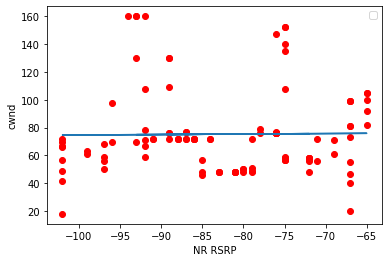

In [69]:
rsrp_l = []
cwnd_l = []
for i in range(len(NR_X_list)):
    rsrp_l.append([NR_X_list[i], NR_Y_list[i]])
rsrp_l = np.array(rsrp_l)


for i in range(len(x)):
    cwnd_l.append([x[i], y[i]])
cwnd_l = np.array(cwnd_l)



i = 0
j = 0
cor = []
while i + 1< len(rsrp_l) and j < len(cwnd_l):
    if rsrp_l[i, 0] > cwnd_l[j, 0]:
        j += 1
    elif rsrp_l[i, 0] < 0:
        i += 1
    elif cwnd_l[j, 0] < 0:
        j += 1
    elif rsrp_l[i + 1, 0] < cwnd_l[j, 0]:
        i += 1
    else:
        if rsrp_l[i, 1] < -85 and cwnd_l[j, 1] > 200:
            j += 1
        else:
            plt.scatter(rsrp_l[i, 1], cwnd_l[j, 1], c = 'r')
            cor.append([rsrp_l[i, 1], cwnd_l[j, 1]])
            j += 1

plt.xlabel("NR RSRP")
plt.ylabel("cwnd")
plt.legend()
cor = np.array(cor)
print(np.corrcoef(cor[:, 0], cor[:, 1]))
z = np.polyfit(cor[:, 0], cor[:, 1], 1)
p = np.poly1d(z)
plt.plot(cor[:, 0], p(cor[:, 0]))

In [18]:
savefilename = '/home/wmnlab/D/jy/lteholocation.csv'
get_location_by_time(lte_handover_time_list, cellinfo_df, savefilename)

In [10]:
savefilename = '/home/wmnlab/D/jy/nrholocation.csv'
get_location_by_time(nr_handover_time_list, cellinfo_df, savefilename)

2022-06-20 18:09:10 2022-06-20 18:09:10.195300 25.00559946 121.55700284
2022-06-20 18:09:10 2022-06-20 18:09:10.196489 25.00559946 121.55700284
2022-06-20 18:09:40 2022-06-20 18:09:40.555245 25.00559635 121.55699446
2022-06-20 18:09:40 2022-06-20 18:09:40.556457 25.00559635 121.55699446
2022-06-20 18:10:30 2022-06-20 18:10:30.035138 25.00559551 121.55699231
2022-06-20 18:10:30 2022-06-20 18:10:30.036344 25.00559551 121.55699231
2022-06-20 18:10:55 2022-06-20 18:10:55.142959 25.00559413 121.55698887
2022-06-20 18:10:55 2022-06-20 18:10:55.144098 25.00559413 121.55698887
2022-06-20 18:11:35 2022-06-20 18:11:35.995099 25.00559401 121.55698681
2022-06-20 18:11:35 2022-06-20 18:11:35.996279 25.00559401 121.55698681
2022-06-20 18:12:26 2022-06-20 18:12:26.354571 25.00559383 121.5569848
2022-06-20 18:12:26 2022-06-20 18:12:26.355811 25.00559383 121.5569848
2022-06-20 18:12:41 2022-06-20 18:12:41.674531 25.00559352 121.55698368
2022-06-20 18:12:41 2022-06-20 18:12:41.675726 25.00559352 121.556

In [71]:
pcap_path = "/home/wmnlab/D/jy/cwnddata/DL_3271_2022-7-2-23-08-18_pcap.csv"
pcap_df = read_pcapcsv(pcap_path)
ret_time_list = get_ret(pcap_df)

In [72]:
mi_file_path = "/home/wmnlab/D/jy/cwnddata/diag_log_20220702_231703_0671099f5f510de3f1c7c89d918aedc0_Xiaomi-M2007J3SY_46697.mi2log.txt_3.csv"
mi_df = pd.read_csv(mi_file_path)
mi_df.loc[:, "time"] = pd.to_datetime(mi_df.loc[:, "time"]) + dt.timedelta(hours=8)


In [73]:
cellinfo_path = "/home/wmnlab/D/jy/cwnddata/070222110759_new.csv"
cellinfo_df = pd.read_csv(cellinfo_path)
cellinfo_df.loc[:, "Date"] = pd.to_datetime(cellinfo_df.loc[:, "Date"])

In [74]:
cellinfo_df

,Date,GPSLat,GPSLon,GPSSpeed,RxRate,TxRate,DLBandwidth,ULBandwidth,MNC,MCC,...,-.70,-.71,-.72,-.73,-.74,-.75,-.76,-.77,-.78,-.79
0,2022-07-02 23:07:59,-,-,-,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
1,2022-07-02 23:08:01,-,-,-,64,116,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
2,2022-07-02 23:08:02,-,-,-,216,52,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
3,2022-07-02 23:08:03,-,-,-,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
4,2022-07-02 23:08:04,25.0158022,121.54212407,0.59,0,0,102400,51200,97,466,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2022-07-02 23:16:59,24.98567971,121.53357166,11.14,9532894,153973,258988,9894,97,466,...,-,-,-,-,-,-,-,-,-,-
508,2022-07-02 23:17:00,24.9855801,121.53358589,10.99,0,0,258988,9894,97,466,...,-,-,-,-,-,-,-,-,-,-
509,2022-07-02 23:17:01,24.98548085,121.53359129,11.03,1136,540,258988,9894,97,466,...,-,-,-,-,-,-,-,-,-,-
510,2022-07-02 23:17:02,24.98538105,121.53359381,11.01,0,0,258988,9894,97,466,...,-,-,-,-,-,-,-,-,-,-


In [79]:
lte_handover_time_list = get_lte_handover_time(mi_df, pcap_df)
nr_handover_time_list = get_nr_handover_time(mi_df, pcap_df)
faliure_time_list = get_failure_time(mi_df, pcap_df)

2022-07-02 23:08:23.970513 2022-07-02 23:16:58.069304


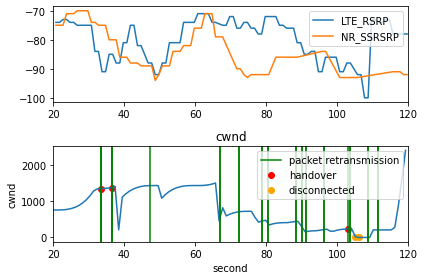

In [80]:
ss_filename = '/home/wmnlab/D/jy/cwnddata/ss_server_DL_3271_2022-7-2-23-08-18.csv'
ss_df = read_ss_file(ss_filename)
begin_time = max(ss_df.loc[0, "time"], mi_df.loc[0, "time"] )
# plt.plot(ss_df.loc[:, "time"]-begin_time, ss_df.loc[:, "cwnd"])

# LTE RSRP
LTE_X_list = []
LTE_Y_list = []

NR_X_list = []
NR_Y_list = []


plt.subplot(2, 1, 1)

for i in range(len(cellinfo_df)):
    if cellinfo_df.loc[i, "LTE_RSRP"] != "-":
        if 20 <= (cellinfo_df.loc[i, "Date"] - begin_time).total_seconds() <= 120:
            LTE_X_list.append((cellinfo_df.loc[i, "Date"] - begin_time).total_seconds())
            LTE_Y_list.append(cellinfo_df.loc[i, "LTE_RSRP"])

plt.plot(LTE_X_list, LTE_Y_list, label = "LTE_RSRP")


for i in range(len(cellinfo_df)):
    if cellinfo_df.loc[i, "NR_SSRSRP"] != "-":
        if 20 <= (cellinfo_df.loc[i, "Date"] - begin_time).total_seconds() <= 120:

            NR_X_list.append((cellinfo_df.loc[i, "Date"] - begin_time).total_seconds())
            NR_Y_list.append(int(cellinfo_df.loc[i, "NR_SSRSRP"]))

plt.plot(NR_X_list, NR_Y_list, label = "NR_SSRSRP")


plt.xlim(left = 20, right = 120)

plt.legend(loc="upper right")


x = []
y = []
for i in range(len(ss_df)):
    if 20 <= (ss_df.loc[i, "time"] - begin_time).total_seconds() <= 120:
        x.append((ss_df.loc[i, "time"]-begin_time).total_seconds())
        y.append(ss_df.loc[i, "cwnd"])


plt.subplot(2, 1, 2)

plt.plot(x, y)

for handovertime in lte_handover_time_list + nr_handover_time_list:
    plt.axvline((handovertime - begin_time).total_seconds(), c = 'g', label = "packet retransmission")



i = 0
j = 0

while i + 1< len(ss_df) and j < len(lte_handover_time_list):
    if ss_df.loc[i, "time"] > lte_handover_time_list[j]:
        j += 1
    elif ss_df.loc[i + 1, "time"] < lte_handover_time_list[j]:
        i += 1
    else:
        plt.scatter((ss_df.loc[i, "time"] - begin_time).total_seconds(), ss_df.loc[i, "cwnd"], c = 'r', label = "handover")
        j += 1

i = 0
j = 0

while i + 1< len(ss_df) and j < len(faliure_time_list):
    if ss_df.loc[i, "time"] > faliure_time_list[j]:
        j += 1
    elif ss_df.loc[i + 1, "time"] < faliure_time_list[j]:
        i += 1
    else:
        plt.scatter((ss_df.loc[i, "time"] - begin_time).total_seconds(), ss_df.loc[i, "cwnd"], c = 'orange', label = "disconnected")
        j += 1



handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title("cwnd")
plt.legend(by_label.values(), by_label.keys(), loc="upper right")
plt.xlabel("second")
plt.ylabel("cwnd")
plt.xlim(left = 20, right = 120)

plt.tight_layout()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[1.         0.37990228]
 [0.37990228 1.        ]]


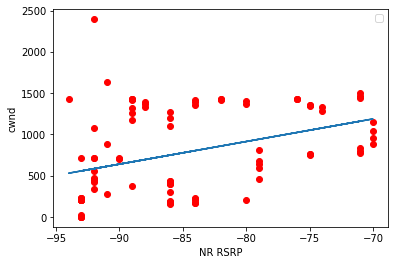

In [78]:
rsrp_l = []
cwnd_l = []
for i in range(len(NR_X_list)):
    rsrp_l.append([NR_X_list[i], NR_Y_list[i]])
rsrp_l = np.array(rsrp_l)


for i in range(len(x)):
    cwnd_l.append([x[i], y[i]])
cwnd_l = np.array(cwnd_l)



i = 0
j = 0
cor = []
while i + 1< len(rsrp_l) and j < len(cwnd_l):
    if rsrp_l[i, 0] > cwnd_l[j, 0]:
        j += 1
    elif rsrp_l[i, 0] < 0:
        i += 1
    elif cwnd_l[j, 0] < 0:
        j += 1
    elif rsrp_l[i + 1, 0] < cwnd_l[j, 0]:
        i += 1
    else:
        plt.scatter(rsrp_l[i, 1], cwnd_l[j, 1], c = 'r')
        cor.append([rsrp_l[i, 1], cwnd_l[j, 1]])
        j += 1

plt.xlabel("NR RSRP")
plt.ylabel("cwnd")
plt.legend()
cor = np.array(cor)
print(np.corrcoef(cor[:, 0], cor[:, 1]))
z = np.polyfit(cor[:, 0], cor[:, 1], 1)
p = np.poly1d(z)
plt.plot(cor[:, 0], p(cor[:, 0]))